In [1]:
# Dependencies
import requests
from dotenv import load_dotenv
import os
import pandas as pd
from bs4 import BeautifulSoup
import scipy.stats as st
import matplotlib.pyplot as plt
import subprocess
import time
from requests.exceptions import ConnectTimeout, ReadTimeout, RequestException
import numpy as np 

In [2]:
# Set environment variables from the .env in the local environment
def key_check(key_path=None):
    try:
        reply=load_dotenv(key_path,verbose=True,override=True)   
        assert reply , 'Dotenv is not found'
        fred_api_key = os.getenv("FRED_API_KEY")
        assert fred_api_key is not None, 'FRED_API_KEY not found in .env file'
        responce=requests.get(f'https://api.stlouisfed.org/fred/category/series?category_id=125&api_key={fred_api_key}')
        assert responce.status_code == 200, f'The key provided failed to authenticate tmdb_api_key {fred_api_key} code {responce.status_code}'
    except Exception as e:
        # Handle potential errors in loading .env or missing API keys
        print(f'An error occurred: {e}')
        return(False)
    else:
        print('All keys loaded correctly')
        return (True)



In [3]:
def run_notebook(path):
    """Run a Jupyter Notebook via nbconvert and capture its output."""
    cmd = ['jupyter', 'nbconvert', '--to', 'notebook', '--execute',
           '--output', path, path]
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return result

In [4]:
# read the file into a list
def load_series_id():
    # retry variables
    max_attempts = 3
    attempts = 0
    # List of notebook paths
    notebooks = ['c:/SRC/AI/ProjectOne_Team2/Frank_playground/Fred_get_HPI.ipynb',
                'c:/SRC/AI/ProjectOne_Team2/Frank_playground/Fred_get_HHI.ipynb',
                'c:/SRC/AI/ProjectOne_Team2/Frank_playground/Fred_get_POP.ipynb']
    # Start load Series_id_df
    while attempts < max_attempts:
        try:
            hpi_series_df = pd.read_csv('C:\\SRC\\AI\\ProjectOne_Team2\\resources\\TX_County_HPI_ID.csv',index_col='County')
            hhi_series_df = pd.read_csv('C:\\SRC\\AI\\ProjectOne_Team2\\resources\\TX_County_HHI_ID.csv',index_col='County')
            pop_series_df = pd.read_csv('C:\\SRC\\AI\\ProjectOne_Team2\\resources\\TX_County_POP_ID.csv',index_col='County')
            final_merged_df = hpi_series_df.join([hhi_series_df, pop_series_df], how='inner')
            display (final_merged_df.head(3))
            print("Files loaded successfully.")
            return final_merged_df
        except FileNotFoundError:
            print(f"Attempt {attempts + 1} failed. Trying to regenerate files.")
            # Start each notebook in a separate process
            processes = [subprocess.Popen(['jupyter', 'nbconvert', '--to', 'notebook', '--execute',
                '--output', nb, nb], stdout=subprocess.PIPE, stderr=subprocess.PIPE) for nb in notebooks] 
            # Wait for all processes to complete
            for proc in processes:
                proc.wait()
            # Increment the attempt counter
            attempts += 1


In [5]:
# this section of code make a request and permits up to max_retries 
def get_page(url, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            # Attempt to make the HTTP GET request with a specified timeout
            response = requests.get(url, timeout=2)  # adding a sensible timeout
            # If the request is successful, break out of the loop
            if response.status_code == 200:
                return response.json()
            if response.status_code == 404:
                return None , None
        except (ConnectTimeout, ReadTimeout) as e:
            # Print an error message showing the retry attempt
            print(f"Attempt {retries + 1} of {max_retries} failed with timeout. Retrying...")
            retries += 1
            if retries == max_retries:
                print("Max retries exceeded. Failing...")
                raise  # Re-raise the last exception after final attempt
        except RequestException as e:
            print(f"Attempt {retries + 1} failed with a request exception: {e}. Retrying...")
            retries += 1
            if retries == max_retries:
                print("Max retries exceeded with request exceptions. Failing...")
                raise
        except: 
            return None, None

    # If all retries are exhausted without a return, it indicates a failure
    print("Request failed after maximum retries.")
    return None, None


In [6]:
#  Set variable for all cells

rt_start='&observation_start=1997-01-01'
rt_end='&observation_end=2022-01-01'
series_corr_list=[]


In [7]:
# get API keys
my_env_path='C:\SRC\AI\ProjectOne_Team2\Frank_playground\keys.env'
if key_check(my_env_path):
    fred_api_key = os.getenv("FRED_API_KEY")
else: 
    print ('fix Keys and rerun')
    
# Load Series ID by county for HPI, HHI and POP
county_series_ids=load_series_id()
series_hpi = []
series_hhi = []
series_pop = []

# retrieve data by county for HPI, HHI and POP for date rage set in VAR
for index, row in county_series_ids.iterrows():
    # Get HPI
    series_id=county_series_ids.loc[index,'HPI ID']
    url = (f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}{rt_start}{rt_end}&api_key={fred_api_key}&file_type=json")
    series = get_page(url)

    for item in series["observations"]:
        if item['value'] != '.':
                series_hpi.append({'county' : index,'date': item['date'], 'value': item['value']})      
    
    # get HHI
    series_id=county_series_ids.loc[index,'HHI ID']
    url = (f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}{rt_start}{rt_end}&api_key={fred_api_key}&file_type=json")
    series = get_page(url)

    for item in series["observations"]:
        if item['value'] != '.':
                series_hhi.append({'county' : index,'date': item['date'], 'value': item['value']})

    # get POP
    series_id=county_series_ids.loc[index,'POP ID']
    url = (f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}{rt_start}{rt_end}&api_key={fred_api_key}&file_type=json")
    series = get_page(url)

    for item in series["observations"]:
        if item['value'] != '.':
                series_pop.append({'county' : index,'date': item['date'], 'value': item['value']})
 

All keys loaded correctly


,HPI ID,HHI ID,POP ID
County,,,
Anderson County,ATNHPIUS48001A,MHITX48001A052NCEN,TXANDE1POP
Andrews County,ATNHPIUS48003A,MHITX48003A052NCEN,TXANDR3POP
Angelina County,ATNHPIUS48005A,MHITX48005A052NCEN,TXANGE5POP


Files loaded successfully.


In [8]:
   
hpi_df = pd.DataFrame(series_hpi)
hpi_df = (
         hpi_df
        .assign(date=lambda df: pd.to_datetime(df['date']))  # Convert 'date' to datetime
        .rename(columns={'value': 'HPI'})   # Rename 'value' column to 'HPI'
        .set_index(['county', 'date'])                  # Set 'date' as the index
        .dropna()                           # Drop rows with NaN values
        )
hhi_df = pd.DataFrame(series_hhi)
hhi_df = (
         hhi_df
        .assign(date=lambda df: pd.to_datetime(df['date']))  # Convert 'date' to datetime
        .rename(columns={'value': 'HHI'})   # Rename 'value' column to 'HPI'
        .set_index(['county', 'date'])                    # Set 'date' as the index
        .dropna()                           # Drop rows with NaN values
        )
pop_df = pd.DataFrame(series_pop)
pop_df = (
         pop_df
        .assign(date=lambda df: pd.to_datetime(df['date']))     # Convert 'date' to datetime
        .rename(columns={'value': 'POP'})                       # Rename 'value' column to 'HPI'
        .set_index(['county', 'date'])                          # Set 'date' as the index
        .sort_index(ascending=[False,True])
        #.dropna()                                               # Drop rows with NaN values
        )
tced_df= hpi_df.join(hhi_df, how='inner').join(pop_df, how='inner')
tced_df['HPI'] = tced_df['HPI'].astype(float)
tced_df['HHI'] = tced_df['HHI'].astype(float)
tced_df['POP'] = tced_df['POP'].astype(float)
display (tced_df.info())
display (tced_df.head())
file_path = f"../resources/TX_Counties_ECO_Data.csv"  # Construct file path with .csv extension
tced_df.to_csv(file_path, index=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3427 entries, ('Anderson County', Timestamp('1997-01-01 00:00:00')) to ('Young County', Timestamp('2022-01-01 00:00:00'))
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HPI     3427 non-null   float64
 1   HHI     3427 non-null   float64
 2   POP     3427 non-null   float64
dtypes: float64(3)
memory usage: 96.8+ KB


None

HPI      HHI     POP
county          date                               
Anderson County 1997-01-01   91.01  29760.0  54.051
                1998-01-01   92.84  30638.0  54.290
                1999-01-01   97.80  30385.0  54.876
                2000-01-01  100.00  31930.0  55.061
                2001-01-01  104.39  31113.0  54.127

                          HPI       HHI       POP
county                                           
Anderson County HPI  1.000000  0.972205  0.720988
                HHI  0.972205  1.000000  0.741160
                POP  0.720988  0.741160  1.000000
Andrews County  HPI  1.000000  0.940679  0.931231
                HHI  0.940679  1.000000  0.939503
...                       ...       ...       ...
Yoakum County   HHI  0.967295  1.000000  0.736490
                POP  0.696346  0.736490  1.000000
Young County    HPI  1.000000  0.936721  0.358887
                HHI  0.936721  1.000000  0.420288
                POP  0.358887  0.420288  1.000000

[399 rows x 3 columns]


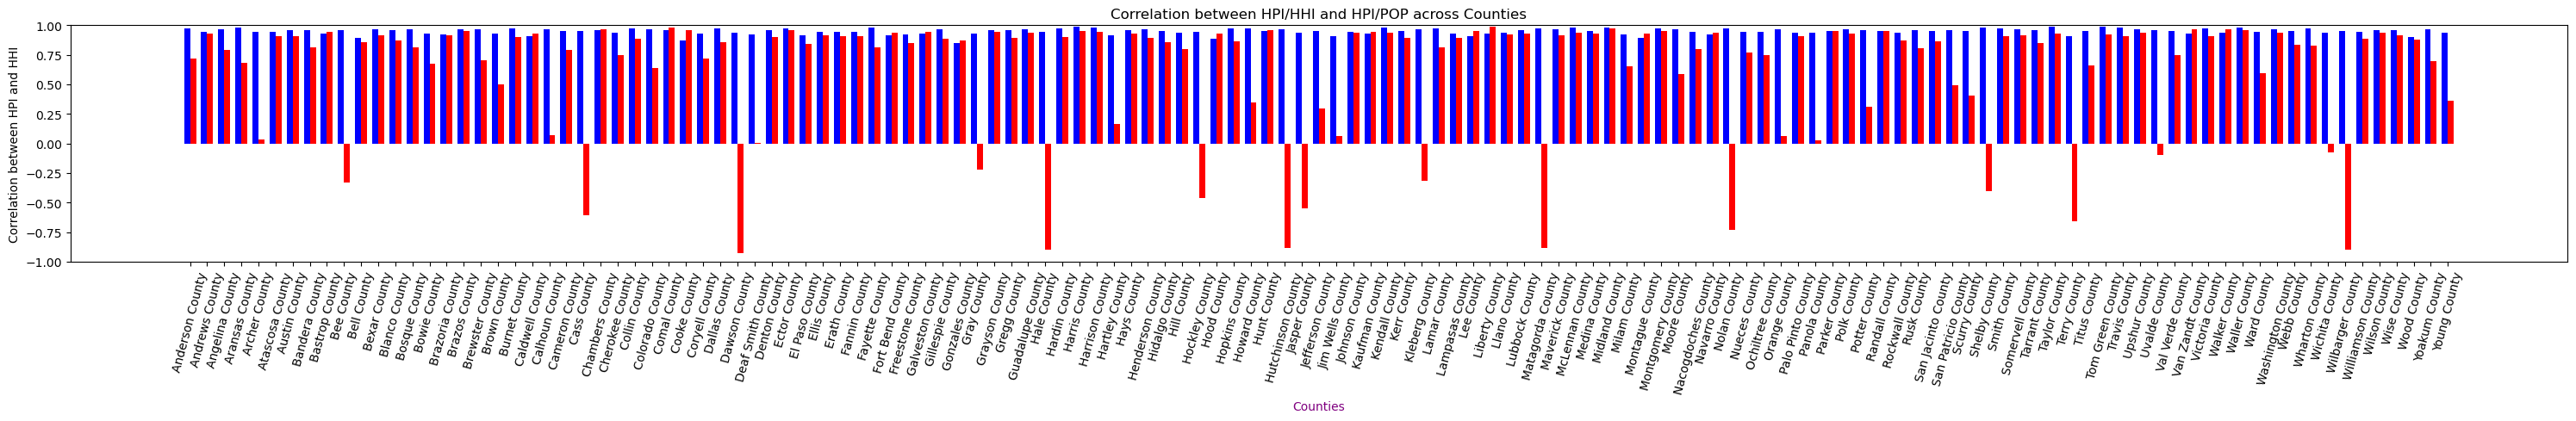

In [9]:
## get the hpi/hhi coorilation
correlation_by_county = tced_df.groupby(level='county').corr()
print(correlation_by_county)
  
correlation_hhi_dict = {}
correlation_pop_dict = {}
for county in tced_df.index.get_level_values('county').unique():
    # Directly access the correlation matrix already computed
    hpi_hhi_corr = correlation_by_county.loc[(county, 'HPI'), 'HHI']
    hpi_pop_corr = correlation_by_county.loc[(county, 'HPI'), 'POP']
    correlation_hhi_dict[county] = hpi_hhi_corr
    correlation_pop_dict[county] = hpi_pop_corr

correlation_hhi_dict = dict(sorted(correlation_hhi_dict.items()))
correlation_pop_dict = dict(sorted(correlation_pop_dict.items()))

# Data preparation
counties_hhi = list(correlation_hhi_dict.keys())
correlations_hhi = list(correlation_hhi_dict.values())
counties_pop = list(correlation_pop_dict.keys())
correlations_pop = list(correlation_pop_dict.values())

# Create an array of positions for the x-axis
x = np.arange(len(counties_hhi))  # the label locations
width = 0.35  # the width of the bars

# Creating the bar plot for multiple counties
plt.figure(figsize=(30, 5))
bars1 = plt.bar(x - width/2, correlations_hhi, width, label='HPI/HHI', color='blue')
bars2 = plt.bar(x + width/2, correlations_pop, width, label='HPI/POP', color='red')
plt.xlabel('Counties',color='purple')
plt.ylabel('Correlation between HPI and HHI')
plt.title('Correlation between HPI/HHI and HPI/POP across Counties')
plt.ylim(-1, 1)  # Assuming correlation values range from 0 to 1
plt.xticks(x, counties_hhi, rotation=75)  # Rotate county names for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

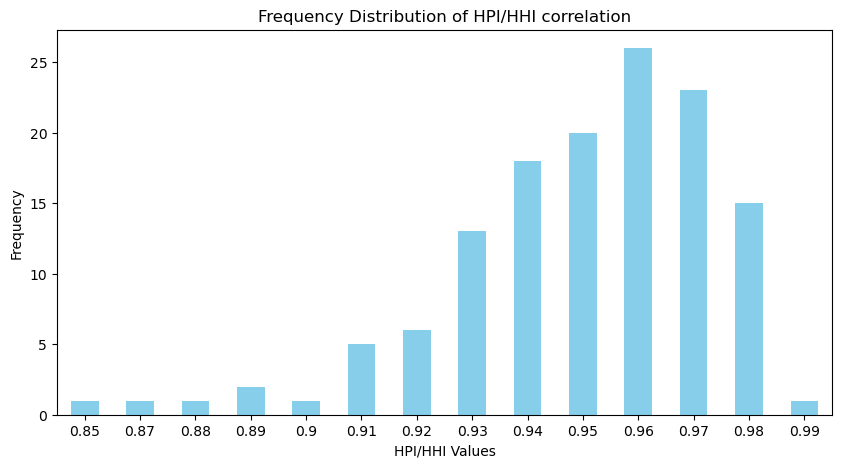

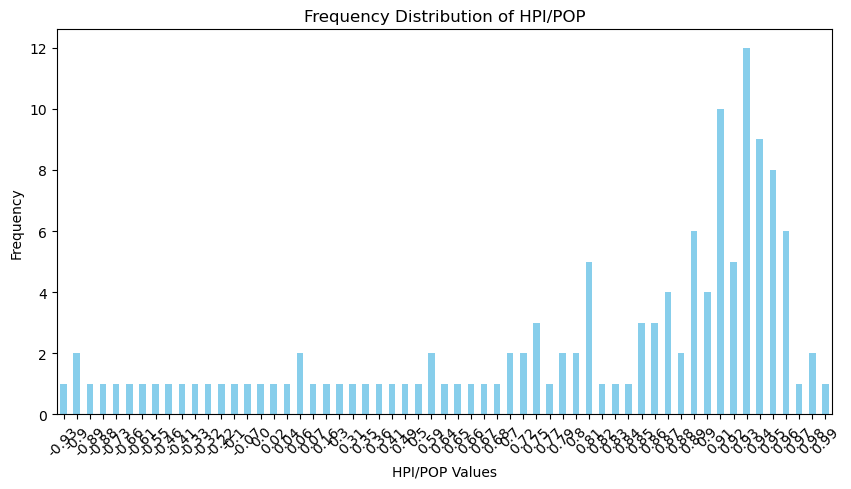

In [10]:


# Count the frequency of each value
round_correlations_hhi =[round(num,2) for num in correlations_hhi]
round_correlations_pop =[round(num,2) for num in correlations_pop]
corr_hhi_series = pd.Series (round_correlations_hhi)
corr_pop_series = pd.Series (round_correlations_pop)
corr_hhi_freq = corr_hhi_series.value_counts().sort_index()
corr_pop_freq = corr_pop_series.value_counts().sort_index()

# Plotting the frequency distribution for HPI/HHI correlation
plt.figure(figsize=(10, 5))
corr_hhi_freq.plot(kind='bar', color='skyblue')  # Customize the color as needed
plt.title('Frequency Distribution of HPI/HHI correlation')
plt.xlabel('HPI/HHI Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Ensures that x-axis labels are horizontal
plt.show()

# Plotting the frequency distribution for HPI/POP correlation
plt.figure(figsize=(10, 5))
corr_pop_freq.plot(kind='bar', color='skyblue')  # Customize the color as needed
plt.title('Frequency Distribution of HPI/POP')
plt.xlabel('HPI/POP Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Ensures that x-axis labels are horizontal
plt.show()